In [1]:
import pandas as pd
import xspec
xspec.AllData.clear()
xspec.AllModels.clear()
xspec.Fit.statMethod = ("cstat")
xspec.Fit.bayes = "on"

xspec_observation = xspec.Spectrum(
    "PN_spectrum_grp20.fits"
)
xspec_observation.background = None

low_energy, high_energy = 0.5, 10.
xspec_observation.ignore(f"0.0-{low_energy:.1f} {high_energy:.1f}-**")

xspec_model = xspec.Model("TBabs*(bbodyrad+powerlaw)")
xspec_model.show()

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

1 spectrum  in use
 
Spectral Data File: PN_spectrum_grp20.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.512e-01 +/- 5.321e-03 (96.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-114
  Telescope: XMM Instrument: EPN  Channel Type: PI
  Exposure Time: 2.027e+04 sec
 Using fit statistic: cstat
 Using Background File                PNbackground_spectrum.fits
  Background Exposure Time: 2.027e+04 sec
 Using Response (RMF) File            PN.rmf for Source 1
 Using Auxiliary Response (ARF) File  PN.arf

Net count rate (cts/s) for Spectrum:1  5.687e-01 +/- 5.298e-03
     9 channels (1-9) ignored in spectrum #     1
     1 channels (114) ignored in spectrum #     1


Model TBabs<1>(bbodyrad<2> + powerlaw<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      

In [2]:
from bsixsa.convenience import set_prior_and_build_transform

prior = [
    ("TBabs", "nH", 0., 0.5, "uniform"),       # 10^22    0.100000     +/-  0.0
    ("bbodyrad", "kT", 0., 2., "uniform"),      #   keV      0.550000     +/-  0.0
    ("bbodyrad", "norm", 1e-2, 1, "loguniform"),      #  keV      2.50000      +/-  0.0
    ("powerlaw", "PhoIndex", 0., 5., "uniform"),    #            2.50000      +/-  0.0
    ("powerlaw", "norm", 1e-5, 1e-2, "loguniform"),
]

transformations = set_prior_and_build_transform(xspec_model, prior)

  uniform prior for nH between 0.000000 and 0.500000 
  uniform prior for kT between 0.000000 and 2.000000 
  jeffreys prior for norm between 1.000000e-02 and 1.000000e+00 
  uniform prior for PhoIndex between 0.000000 and 5.000000 
  jeffreys prior for norm between 1.000000e-05 and 1.000000e-02 


In [3]:
from bsixsa import SIXSASolver

# Instantiate solver the BXA's way

solver = SIXSASolver(
    transformations,
    outputfiles_basename="sixsa_result_sri/",
    use_background=False
)

In [4]:
import numpy as np
from bsixsa.summary_stats import merge_summary, summary_statistics_func

# Get the energy grid used by XSPEC
energy_spectrum = np.asarray(xspec.AllData(1).energies).T

# Define the summary statistics
def full_spectrum_statistics_func(spectra):
    energy_grid = np.geomspace(energy_spectrum.min(), energy_spectrum.max(), 20)
    return summary_statistics_func(spectra, energy_grid=energy_grid)

# One can add other func to compute them
summary_list = [full_spectrum_statistics_func]
embedding_func = merge_summary(*summary_list)

In [5]:
training_kwargs = dict(
    discard_prior_samples=False,
    force_first_round_loss=True,
    retrain_from_scratch=False
)

# Run the inference over 5 rounds of 5k samples
posterior = solver.run(num_rounds=5, num_simulations=5_000, training_kwargs=training_kwargs, embedding=embedding_func)

Round 1 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 114 epochs.

Round 2 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.

Round 3 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Round 4 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

Round 5 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 71 epochs.

Computing posterior statistic - Folding model:   0%|          | 0/1000 [00:00<?, ?it/s]

   All chains are now removed.
  New chain sixsa_result_sri/chain.fits is now loaded.
  Default chain length is now set to length of sixsa_result_sri/chain.fits: 1000


  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.
***Warning: Fit is not current.
***Warning: Fit is not current.



***XSPEC Error: Requested array does not exist for this plot.


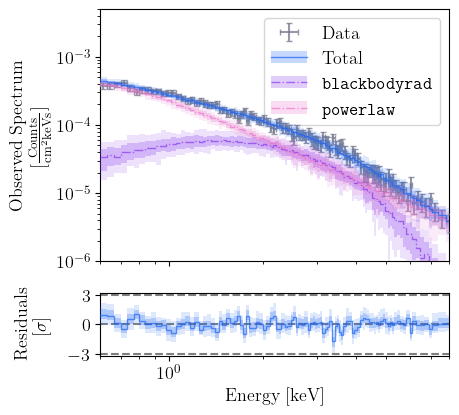

In [6]:
import matplotlib
from matplotlib import rc
from bsixsa.plotting_stuff import plot_ppc

# Activate latex text rendering
rc('font',**{'family':'serif','serif':['Computer Modern Roman'], 'size':13})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

# Posterior plot
component_names = ["Total", r"$\texttt{blackbodyrad}$", r"$\texttt{powerlaw}$"]

fig = plot_ppc(solver, component_names=component_names, x_lim=(0.6, 8.), y_lim=(1e-6, 5e-3), plot_background=False, figsize=(4.5, 4.5))
fig.savefig("ppc.pdf", bbox_inches="tight");

In [7]:
solver.posterior_dataframe()

,nH,kT,norm (bb_1),PhoIndex,norm (po_2)
0,0.100953,0.791546,0.145494,2.195243,0.000320
1,0.111072,0.764586,0.167098,2.167557,0.000301
2,0.092376,0.788838,0.144171,2.152705,0.000293
3,0.099889,0.811372,0.146240,2.122267,0.000319
4,0.095304,0.781639,0.146907,2.094467,0.000305
...,...,...,...,...,...
9995,0.086113,0.742762,0.188330,2.055526,0.000286
9996,0.093600,0.786156,0.160209,2.111529,0.000291
9997,0.052304,0.728558,0.185246,1.978975,0.000260
9998,0.083054,0.740660,0.213081,2.194691,0.000278


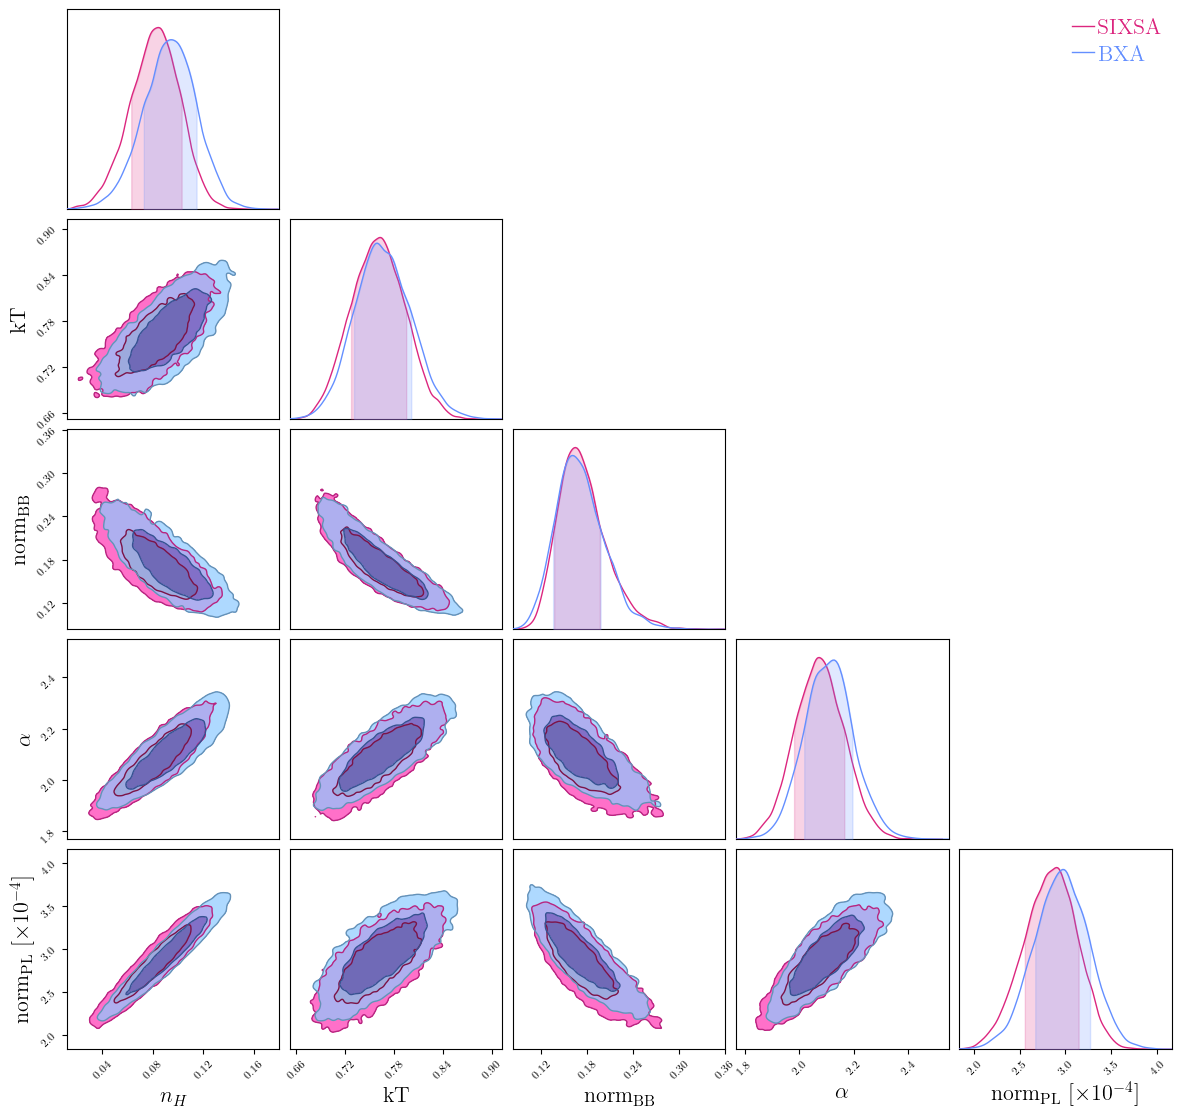

In [8]:
import pandas as pd
from chainconsumer import ChainConsumer, Chain, PlotConfig

bxa_df = pd.read_csv("bxa_dataframe.csv")
sixsa_df = solver.posterior_dataframe()

bxa_df.rename(columns=
    {
        "tbabs_1_nh": "nH",
        "blackbodyrad_1_kT":"kT",
        "blackbodyrad_1_norm":"norm (bb_1)",
        "powerlaw_1_alpha":"PhoIndex",
        "powerlaw_1_norm":"norm (po_2)"
    },
    inplace=True
)

cc = ChainConsumer()
cc.add_chain(Chain(samples=sixsa_df, name="SIXSA", color="#dc267f"))
cc.add_chain(Chain(samples=bxa_df, name="BXA", color="#648fff"))
cc.set_plot_config(
    PlotConfig(
        usetex=True,
        label_font_size=16,
        tick_font_size=8,
        serif=True,
        labels={
            "kT": r"$kT$",
            "PhoIndex": r"$\alpha$",
            "nH": r"$n_H$",
            "norm (bb_1)": r"$\text{norm}_{\text{BB}}$",
            "norm (po_2)": r"$\text{norm}_{\text{PL}}$",
        }
    )
)

cc.plotter.plot(filename="posterior.pdf");